# ACML Lab 2: Convolutional Autoencoders
Sree Kotala i6206796
Michal Kalbarczyk i6223513

In [1]:
#Importing the necessary packages.
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

import PIL
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the dataset from a numpy file
data = np.load("cifar-10.npz")
filenames = ['x_train', 'y_train', 'x_test', 'y_test']
nps = []

for filename in filenames:
    nps.append(data[filename])
    
train_images, train_labels, test_images, test_labels = nps

## Util. function for showing feature maps 

In [45]:
def construct_feature_map(model, test_data):
    blocks = []
    for i in range(len(model.layers)):
        if "conv" in model.layers[i].name:
            blocks.append(i)

    outputs = [model.layers[i].output for i in blocks]
    model = Model(inputs=model.inputs, outputs=outputs)
    feature_map = model.predict(test_data[:])

    # Show original image
    plt.title("Original image")
    plt.imshow(test_data[0], cmap="gray")

    for i, fmap in zip(blocks, feature_map):
        fig = plt.figure(figsize=(20,15))

        #https://stackoverflow.com/a/12444777
        fig.suptitle(f"Feature map for convolutional layer {i}", fontsize=20)
        for i in range(1, fmap.shape[2]+1):
            plt.subplot(8,8,i)
            plt.imshow(fmap[:,:,i-1], cmap='gray')

    plt.show()

## Reconstruction

In [4]:
#Prepping transformation(s)

datagen_norm = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
)

# Combine the data -> done to overcome the silly 50k/10k split
X = np.concatenate((train_images, test_images))
y = np.concatenate((train_labels, test_labels))

# Normalize the data
trans_norm = datagen_norm.flow(X, batch_size=len(X))
X = trans_norm.next()


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

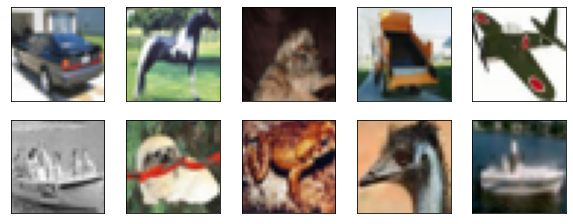

In [5]:
# Plot the images as a sanity check

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
plt.show()

In [54]:
# Build the model
class Autoencoder(Model):

    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Conv2D(8, (3, 3), activation='relu', padding="same", strides=1, input_shape=(32, 32, 3)),
#             layers.MaxPooling2D((2, 2)),
#             layers.Conv2D(12, (3, 3), activation='relu', padding="same", strides=1),
#             layers.MaxPooling2D((2, 2)),
#             layers.Conv2D(32, (3,3), activation='relu', padding="same", strides=1)
        ])

        self.decoder = tf.keras.Sequential([
#             layers.UpSampling2D(size=(2,2)),
#             layers.Conv2D(12, (3, 3), activation='relu', padding="same", strides=1),
#             layers.UpSampling2D(size=(2,2)),
            layers.Conv2D(3, (3, 3), activation='relu', padding="same", strides=1)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [55]:
# Compile the model
autoencoder = Autoencoder()
autoencoder.encoder.summary()
autoencoder.compile(optimizer='adam',
                    loss=losses.MeanSquaredError(),
                    metrics=['mse', 'accuracy'])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 8)         224       
                                                                 
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Train the model
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=64,
                          validation_data=(X_val, X_val))

Epoch 1/10
750/750 [==============================] - 20s 25ms/step - loss: 0.0093 - mse: 0.0093 - accuracy: 0.6958 - val_loss: 7.1437e-04 - val_mse: 7.1437e-04 - val_accuracy: 0.8203
Epoch 2/10
750/750 [==============================] - 17s 23ms/step - loss: 4.4167e-04 - mse: 4.4167e-04 - accuracy: 0.8526 - val_loss: 2.8658e-04 - val_mse: 2.8658e-04 - val_accuracy: 0.8734
Epoch 3/10
750/750 [==============================] - 18s 24ms/step - loss: 2.2393e-04 - mse: 2.2393e-04 - accuracy: 0.8857 - val_loss: 1.7293e-04 - val_mse: 1.7293e-04 - val_accuracy: 0.8948
Epoch 4/10
750/750 [==============================] - 18s 24ms/step - loss: 1.4949e-04 - mse: 1.4949e-04 - accuracy: 0.9011 - val_loss: 1.3477e-04 - val_mse: 1.3477e-04 - val_accuracy: 0.8971
Epoch 5/10
750/750 [==============================] - 17s 22ms/step - loss: 1.1523e-04 - mse: 1.1523e-04 - accuracy: 0.9102 - val_loss: 9.2704e-05 - val_mse: 9.2704e-05 - val_accuracy: 0.9115
Epoch 6/10
750/750 [============================

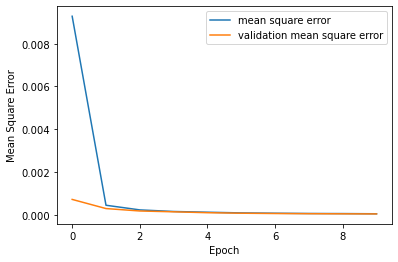

In [57]:
# Plot the valuation metrics
plt.plot(history.history['mse'], label='mean square error')
plt.plot(history.history['val_mse'], label = 'validation mean square error')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.legend(loc='upper right')

In [58]:
# Make the predictions
predictions = autoencoder.predict(X_test[:])

# Evaluate the predictions 
evaluation = autoencoder.evaluate(predictions, X_test)
print(f"\nLoss: {round(evaluation[0],4)}\nMSE: {round(evaluation[1],4)}\nAccuracy: {round(evaluation[2],4)}")

188/188 [==============================] - 1s 5ms/step - loss: 9.9018e-05 - mse: 9.9018e-05 - accuracy: 0.9092

Loss: 0.0001
MSE: 0.0001
Accuracy: 0.9092


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


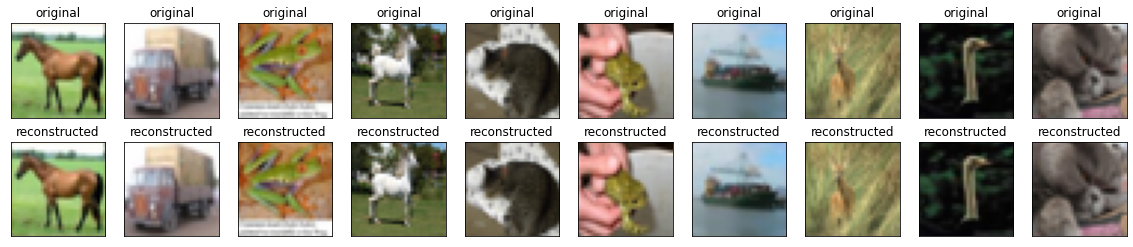

In [59]:
# Check the predictions
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("original")
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i])
    plt.title("reconstructed")
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 8)         224       
                                                                 
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________
1500/1500 [==============================] - 4s 2ms/step


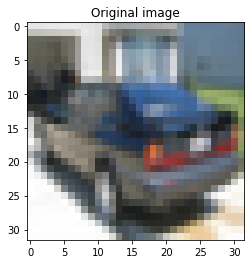

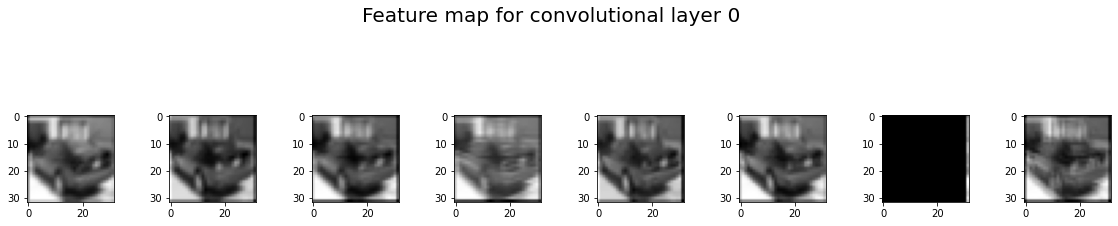

In [60]:
autoencoder.encoder.summary()
model = autoencoder.encoder
construct_feature_map(model, X_train)

#### TODO

Change the metric that we are outputing from accuracy to the mean squared error as the assignment description requires us to report the mean squared error, simple as changing the code into 'metrics=\[metrics.MeanSquaredError()\]' instead of the accuracy being the metric we report.

Add code that calculates the test error output (mean square error so we can compare to the outputs of train and validation)
   - https://github.com/up42/image-similarity-measures/blob/master/image_similarity_measures/quality_metrics.py
      - Could use this website to define an MSE metric that compares an input set of images, change the RMSE to just MSE and cite the source.

Latent space size calculation (maybe find a method that does this or automate it to be used with various models)

Try alternate architectures: e.g. fewer intermediate layers, change num channels, filter sizes, stride, and padding configs.
   - What is the impact of those on the reconstruction error after training.
   - Is there a link between the size of the latent space representation and the error (from your tests)


## Colorization

Adapt the previous 'best' model to recolorize images from greyscale to RGB

In [61]:
# Prepare additional transformations required for colorization using an autoencoder
def to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    return image

datagen_gray = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=to_grayscale
)

In [62]:
#Creating a copy of the train array to convert to greyscale
X_train_gray = X_train.copy()

In [63]:
# TAKES A MINUTE ON MY COMPUTER

# Apply the transformation
trans_train_gray = datagen_gray.flow(X_train_gray, batch_size=len(X_train),shuffle=False)
trans_test_gray = datagen_gray.flow(X_test, batch_size=len(X_test),shuffle=False)
trans_val_gray = datagen_gray.flow(X_val, batch_size=len(X_val),shuffle=False)

# Store the transformed GRAY images
X_train_gray = trans_train_gray.next()
X_test_gray = trans_test_gray.next()
X_val_gray = trans_val_gray.next()

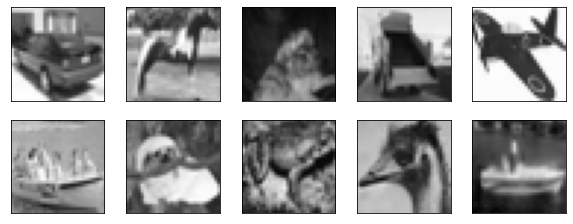

In [64]:
# Plot the images just to be sure the transformations worked

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_gray[i])
plt.show()

In [ ]:
# Train the colorization model
history = autoencoder.fit(X_train_gray, X_train, epochs=10, batch_size=64,
                          validation_data=(X_val_gray, X_val))

Epoch 1/10
750/750 [==============================] - 17s 23ms/step - loss: 0.0063 - mse: 0.0063 - accuracy: 0.4332 - val_loss: 0.0061 - val_mse: 0.0061 - val_accuracy: 0.4830
Epoch 2/10
750/750 [==============================] - 17s 22ms/step - loss: 0.0063 - mse: 0.0063 - accuracy: 0.4398 - val_loss: 0.0061 - val_mse: 0.0061 - val_accuracy: 0.4819
Epoch 3/10
750/750 [==============================] - 17s 22ms/step - loss: 0.0063 - mse: 0.0063 - accuracy: 0.4397 - val_loss: 0.0061 - val_mse: 0.0061 - val_accuracy: 0.4821
Epoch 4/10
750/750 [==============================] - 17s 22ms/step - loss: 0.0063 - mse: 0.0063 - accuracy: 0.4421 - val_loss: 0.0062 - val_mse: 0.0062 - val_accuracy: 0.4325
Epoch 5/10
750/750 [==============================] - 17s 22ms/step - loss: 0.0063 - mse: 0.0063 - accuracy: 0.4388 - val_loss: 0.0061 - val_mse: 0.0061 - val_accuracy: 0.4906
Epoch 6/10
750/750 [==============================] - 18s 24ms/step - loss: 0.0063 - mse: 0.0063 - accuracy: 0.4374 - va

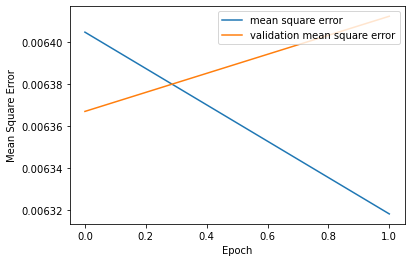

In [66]:
# Plot the valuation metrics
plt.plot(history.history['mse'], label='mean square error')
plt.plot(history.history['val_mse'], label = 'validation mean square error')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.legend(loc='upper right')

In [67]:
# Make the predictions
predictions = autoencoder.predict(X_test_gray[:])

# Evaluate the predictions 
evaluation = autoencoder.evaluate(predictions, X_test)
print(f"\nLoss: {round(evaluation[0],4)}\nMSE: {round(evaluation[1],4)}\nAccuracy: {round(evaluation[2],4)}")

188/188 [==============================] - 1s 6ms/step - loss: 0.0065 - mse: 0.0065 - accuracy: 0.4441

Loss: 0.0065
MSE: 0.0065
Accuracy: 0.4441


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


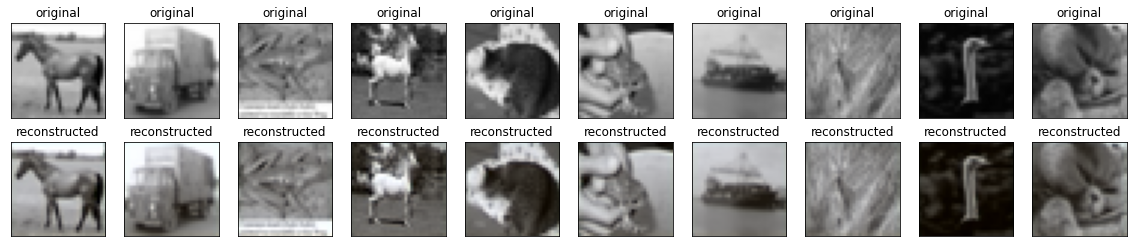

In [68]:
# Check the predictions 
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_gray[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
autoencoder.encoder.summary()
model = autoencoder.encoder
construct_feature_map(model, X_train)

## TODO

Create error function for this part that looks at the difference between the reconstructed image and the output of the reconstruction from the previous portion as then the blurring is taken into consideration adn we see how well our reconstruction performs. We could also look at the error as the diff between output and original test output but then we will see even worse results.

Report on the results and the shortcomings of the approach, What aspects could be improved (of arch, hyper params, optimization) to get a better fit?

Kurt mentioned some hint about looking at predicting the chrominance of the image rather than the colour of the image itself, and then using the Chrominance to recreate the original colour image from the greyscale. This involves the following.
   - Converting the images from RGB space to YCbCr space:
   - Y = Intensity, Cb = Chrominance blue, Cr = Chrominance red
   - (MY IDEA FOR NOW: using knowledge from the SIP course from last period)
        - train different autoencoders, or one that splits into two then combine
            - first one tries to predict Cb from greyscale
            - second tries to predict Cr from greyscale
        - Determine Y from the input, pass through the image into the Cb and Cr autoencoder, then combine YCbCr outputs together. Afterwhich we convert this back into RGB space and present this as the output.